# Time Series Forecasting Comparison

## Imports and Data Loading

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import numpy as np

# Default charting
rcParams['figure.figsize'] = 12,8
sns.set_theme()

### Read in Data

In [2]:
df = pd.read_csv('./data/LD2011_2014.txt', sep=';', decimal=',')
df = df.loc[:,['Unnamed: 0', 'MT_001', 'MT_002']]

In [3]:
df.head()

,Unnamed: 0,MT_001,MT_002
0,2011-01-01 00:15:00,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0


### Unpivot and Format Columns

In [4]:
# Fix unnamed column
df.rename(columns={'Unnamed: 0': 'electricity_timestamp'}, inplace=True)

# Fix timestamp format
df['electricity_timestamp'] = pd.to_datetime(df['electricity_timestamp'])

In [5]:
# Upsample to the day level
df = df.resample('1D', on='electricity_timestamp').sum().reset_index()
df = df.loc[df['electricity_timestamp'] < '2015-01-01', :]

In [6]:
# Unpivot data
df = pd.melt(df, id_vars='electricity_timestamp', value_vars=df.columns[df.columns.str.contains('MT_')])
df.rename(columns={'variable': 'customer_id', 'value': 'consumption_kw'}, inplace=True)

In [7]:
df.tail()

,electricity_timestamp,customer_id,consumption_kw
2917,2014-12-27,MT_002,2145.803698
2918,2014-12-28,MT_002,2131.578947
2919,2014-12-29,MT_002,2212.660028
2920,2014-12-30,MT_002,2205.547653
2921,2014-12-31,MT_002,2273.115220


In [8]:
len(df)

2922

### Plot One Example and Time Slice

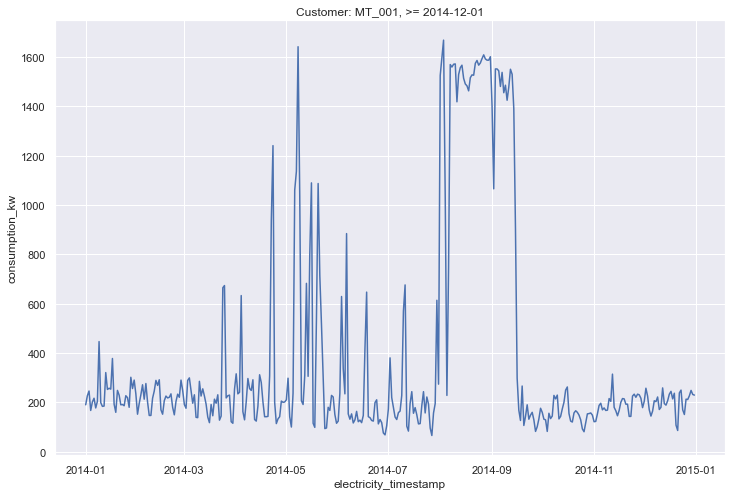

In [9]:
# Plot one example
ax = sns.lineplot(data=df.loc[(df.customer_id=='MT_001') & (df.electricity_timestamp>='2014-01-01'), :], x='electricity_timestamp', y='consumption_kw')
ax.set_title('Customer: MT_001, >= 2014-12-01')
plt.show()

### Build X and Y, Train and Test

In [10]:
df.sort_values(by=['customer_id', 'electricity_timestamp'], inplace=True)
df.head()

,electricity_timestamp,customer_id,consumption_kw
0,2011-01-01,MT_001,0.0
1,2011-01-02,MT_001,0.0
2,2011-01-03,MT_001,0.0
3,2011-01-04,MT_001,0.0
4,2011-01-05,MT_001,0.0


In [11]:
# Add next day target and drop nulls
df['next_consumption_kw'] = df.groupby('customer_id')['consumption_kw'].transform(lambda x: x.shift(-1))
df = df[df['next_consumption_kw'].notnull()]

In [12]:
# Split into train and test based on cutoff dates
train_start_date = '2012-01-01'
test_start_date = '2014-01-01'
df_train = df.loc[(df['electricity_timestamp'] >= train_start_date) & (df['electricity_timestamp'] < test_start_date)]
df_test = df.loc[(df['electricity_timestamp'] >= test_start_date)]

### Standardize Columns

In [13]:
summary_stats = df_train.groupby('customer_id')['consumption_kw'].agg([np.mean, np.std]).reset_index()
df_train = df_train.merge(summary_stats, how='inner', on='customer_id')
df_test = df_test.merge(summary_stats, how='inner', on='customer_id')
df_train.rename(columns={'mean': 'train_mean', 'std': 'train_std'}, inplace=True)
df_test.rename(columns={'mean': 'train_mean', 'std': 'train_std'}, inplace=True)

In [14]:
df_train.consumption_kw = (df_train.consumption_kw - df_train.train_mean) / df_train.train_std
df_train.next_consumption_kw = (df_train.next_consumption_kw - df_train.train_mean) / df_train.train_std
df_test.consumption_kw = (df_test.consumption_kw - df_test.train_mean) / df_test.train_std
df_test.next_consumption_kw = (df_test.next_consumption_kw - df_test.train_mean) / df_test.train_std
df_train.drop(columns=['train_mean', 'train_std'], inplace=True)
df_test.drop(columns=['train_mean', 'train_std'], inplace=True)

### Time Series Features

In [15]:
def add_ts_features(df_ts: pd.DataFrame, lags: int = 7):

    # Simple date extractions
    df_ts = df_ts.assign(
        month = df_ts['electricity_timestamp'].dt.month,
        day = df_ts['electricity_timestamp'].dt.day,
        day_of_week = df_ts['electricity_timestamp'].dt.dayofweek,
        quarter = df_ts['electricity_timestamp'].dt.quarter,
        is_month_end = df_ts['electricity_timestamp'].dt.is_month_end
    )

    # Add N lags as new columns
    for i in range(lags):
        df_ts[f'lag_{i+1}'] = df_ts.groupby('customer_id')['consumption_kw'].transform(lambda x: x.shift(i+1))
    
    # Rolling windows
    df_ts['rolling_mean'] = df_ts.groupby('customer_id')['consumption_kw'].transform(lambda x: x.rolling(window=lags).mean())
    df_ts['rolling_std'] = df_ts.groupby('customer_id')['consumption_kw'].transform(lambda x: x.rolling(window=lags).std())

    # Expanding windows
    df_ts['expanding_window'] = df_ts.groupby('customer_id')['consumption_kw'].transform(lambda x: x.expanding(min_periods=1).mean())

    # Filter out any NAs due to lags
    df_ts = df_ts.dropna(axis=0, how='any', subset=[f'lag_{i+1}' for i in range(lags)])

    return df_ts

In [16]:
df_train = add_ts_features(df_train)
df_test = add_ts_features(df_test)

In [17]:
df_train.head()

,electricity_timestamp,customer_id,consumption_kw,next_consumption_kw,month,day,day_of_week,quarter,is_month_end,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_std,expanding_window
7,2012-01-08,MT_001,0.956462,1.139489,1,8,6,1,False,1.117526,1.468937,1.507983,1.012591,0.910096,0.880811,0.278044,1.122058,0.261985,1.016556
8,2012-01-09,MT_001,1.139489,1.151691,1,9,0,1,False,0.956462,1.117526,1.468937,1.507983,1.012591,0.910096,0.880811,1.159012,0.239570,1.030215
9,2012-01-10,MT_001,1.151691,1.864275,1,10,1,1,False,1.139489,0.956462,1.117526,1.468937,1.507983,1.012591,0.910096,1.193526,0.213743,1.042363
10,2012-01-11,MT_001,1.864275,1.271268,1,11,2,1,False,1.151691,1.139489,0.956462,1.117526,1.468937,1.507983,1.012591,1.315195,0.312959,1.117082
11,2012-01-12,MT_001,1.271268,1.425011,1,12,3,1,False,1.864275,1.151691,1.139489,0.956462,1.117526,1.468937,1.507983,1.281378,0.301225,1.129931


### Training

#### Tree Based

In [18]:
train_y = df_train.pop('next_consumption_kw')
train_x = df_train.loc[:, df_train.columns[2:]]
test_y = df_test.pop('next_consumption_kw')
test_x = df_test.loc[:, df_train.columns[2:]]

In [19]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(train_x, train_y, eval_metric='l2')
cb_model = CatBoostRegressor(loss_function='RMSE', verbose=False)
cb_model.fit(train_x, train_y)

### Scoring

In [20]:
print(f'LightGBM MAE: {mean_absolute_error(test_y, lgb_model.predict(test_x)):.2f}')
print(f'Catboost MAE: {mean_absolute_error(test_y, cb_model.predict(test_x)):.2f}')

LightGBM MAE: 0.26
Catboost MAE: 0.26


In [21]:
predictions = lgb_model.predict(test_x)

### Results Visualization

In [22]:
df_test['prediction'] = predictions
df_test['actual'] = test_y

In [23]:
df_test.head()

,electricity_timestamp,customer_id,consumption_kw,month,day,day_of_week,quarter,is_month_end,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_std,expanding_window,prediction,actual
7,2014-01-08,MT_001,-0.698099,1,8,2,1,False,-0.749346,-0.673695,-0.702979,-0.768869,-0.617567,-0.654172,-0.724943,-0.694961,0.052599,-0.698709,-0.747212,-0.231991
8,2014-01-09,MT_001,-0.231991,1,9,3,1,False,-0.698099,-0.749346,-0.673695,-0.702979,-0.768869,-0.617567,-0.654172,-0.634649,0.184307,-0.646851,-0.468180,-0.707860
9,2014-01-10,MT_001,-0.707860,1,10,4,1,False,-0.231991,-0.698099,-0.749346,-0.673695,-0.702979,-0.768869,-0.617567,-0.647548,0.186064,-0.652952,-0.977759,-0.737144
10,2014-01-11,MT_001,-0.737144,1,11,5,1,False,-0.707860,-0.231991,-0.698099,-0.749346,-0.673695,-0.702979,-0.768869,-0.643016,0.182977,-0.660606,-0.778531,-0.734704
11,2014-01-12,MT_001,-0.734704,1,12,6,1,False,-0.737144,-0.707860,-0.231991,-0.698099,-0.749346,-0.673695,-0.702979,-0.647548,0.185090,-0.666781,-0.920422,-0.473586


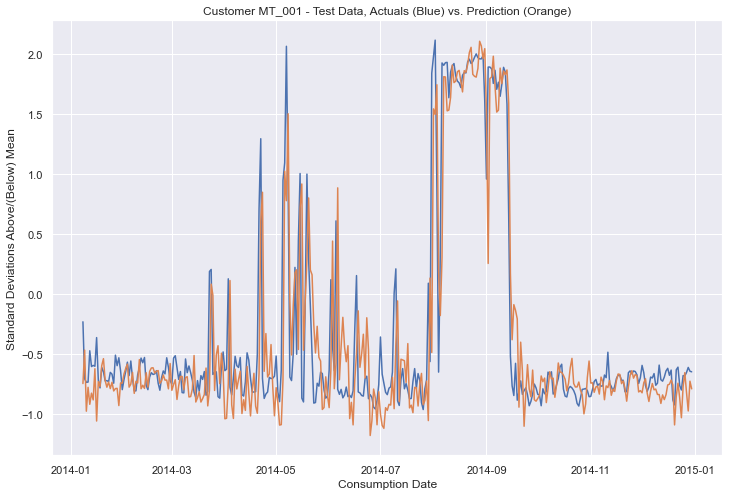

In [24]:
sns.lineplot(data=df_test.loc[df_test.customer_id=='MT_001'], x='electricity_timestamp', y='actual')
sns.lineplot(data=df_test.loc[df_test.customer_id=='MT_001'], x='electricity_timestamp', y='prediction')
plt.title('Customer MT_001 - Test Data, Actuals (Blue) vs. Prediction (Orange)')
plt.ylabel('Standard Deviations Above/(Below) Mean')
plt.xlabel('Consumption Date')
plt.show()

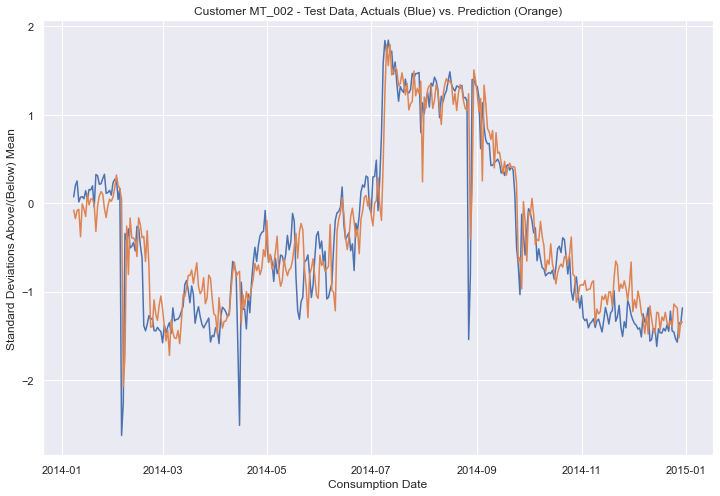

In [25]:
sns.lineplot(data=df_test.loc[df_test.customer_id=='MT_002'], x='electricity_timestamp', y='actual')
sns.lineplot(data=df_test.loc[df_test.customer_id=='MT_002'], x='electricity_timestamp', y='prediction')
plt.title('Customer MT_002 - Test Data, Actuals (Blue) vs. Prediction (Orange)')
plt.ylabel('Standard Deviations Above/(Below) Mean')
plt.xlabel('Consumption Date')
plt.show()